In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/input/test_labels.csv.zip
/content/input/train.csv.zip
/content/input/sample_submission.csv.zip
/content/input/test.csv.zip


In [ ]:
!unzip /content/input/train.csv.zip
!unzip /content/input/test.csv.zip
!unzip /content/input/test_labels.csv.zip
!unzip /content/input/sample_submission.csv.zip

Archive:  /content/input/train.csv.zip
  inflating: train.csv               
Archive:  /content/input/test.csv.zip
  inflating: test.csv                
Archive:  /content/input/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /content/input/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
### Config File
TRAIN = './train.csv'
TEST = './test.csv'
TEST_LABEL = './test_labels.csv'
SAMPLE = './sample_submission.csv'
EPOCHS = 2
MAX_TOKEN_COUNT = 128
BATCH_SIZE = 32

In [ ]:
!pip3 install transformers
!pip3 install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.8 MB/s 
     |████████████████████████████████| 182 kB 45.1 MB/s 
     |████████████████████████████████| 7.6 MB 37.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 6.5 MB/s 
     |████████████████████████████████| 125 kB 63.0 MB/s 
     |████████████████████████████████| 529 kB 54.3 MB/s 
     |████████████████████████████████| 87 kB 7.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=7e255fa3e980a7e8b546b993c45b8630092aa494e9a98ace3a4ba52f314deb74
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

In [ ]:
df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)
test_label = pd.read_csv(TEST_LABEL)
sample_sub = pd.read_csv(SAMPLE)
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_label.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


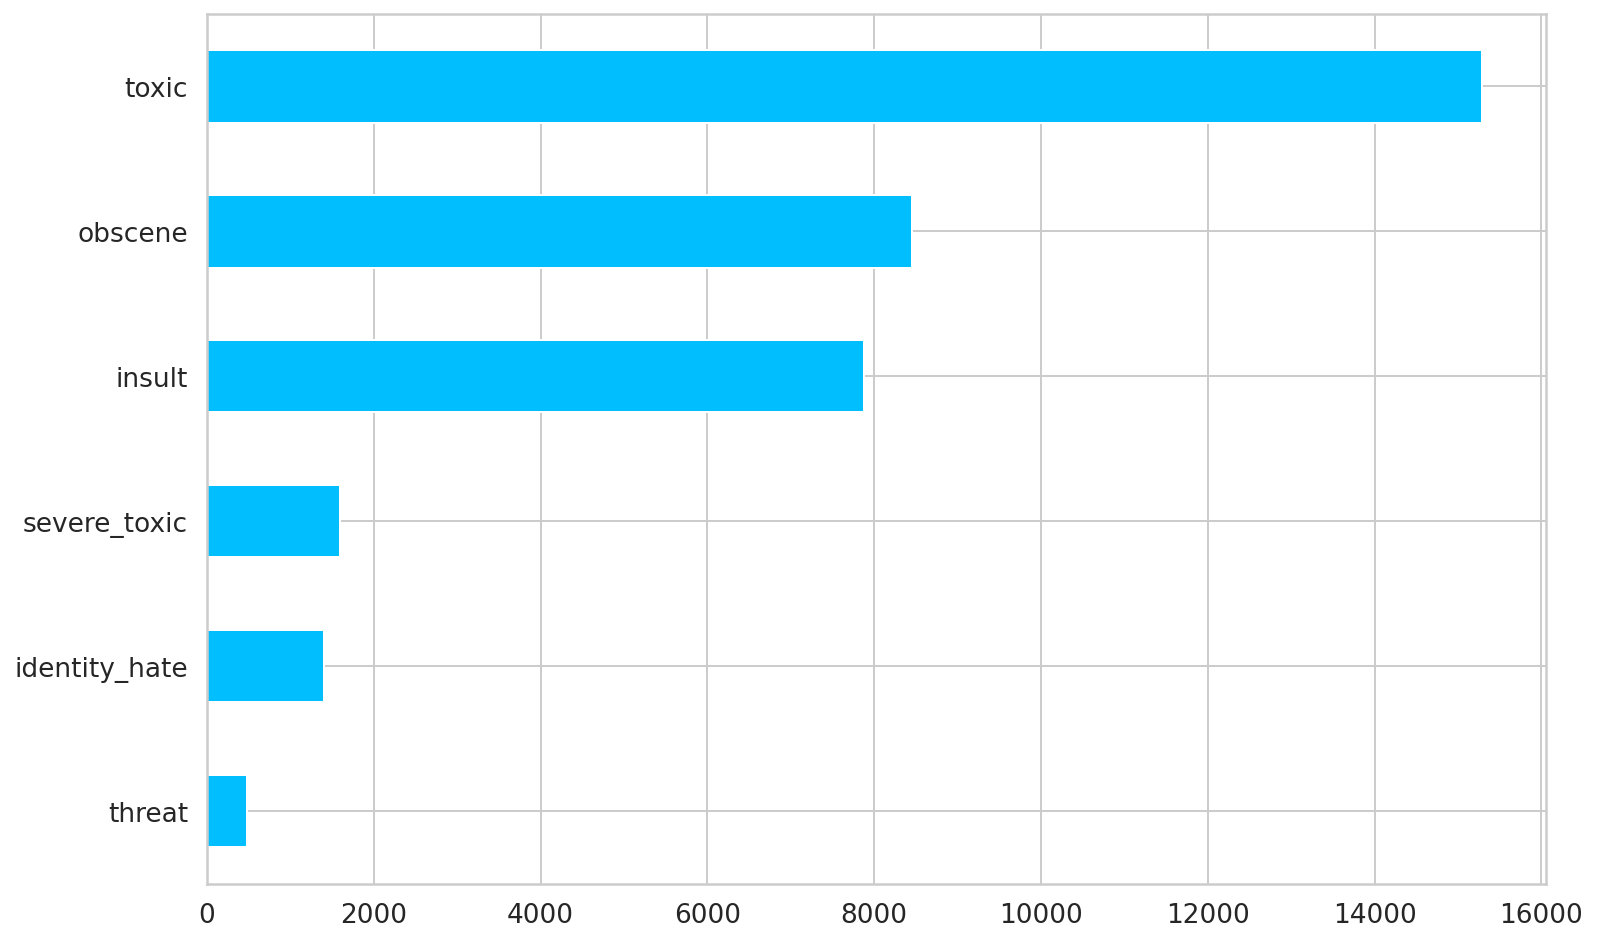

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape, test_df.shape #test hs only ids and comment_text

LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");



((30427, 8), (7979, 8))

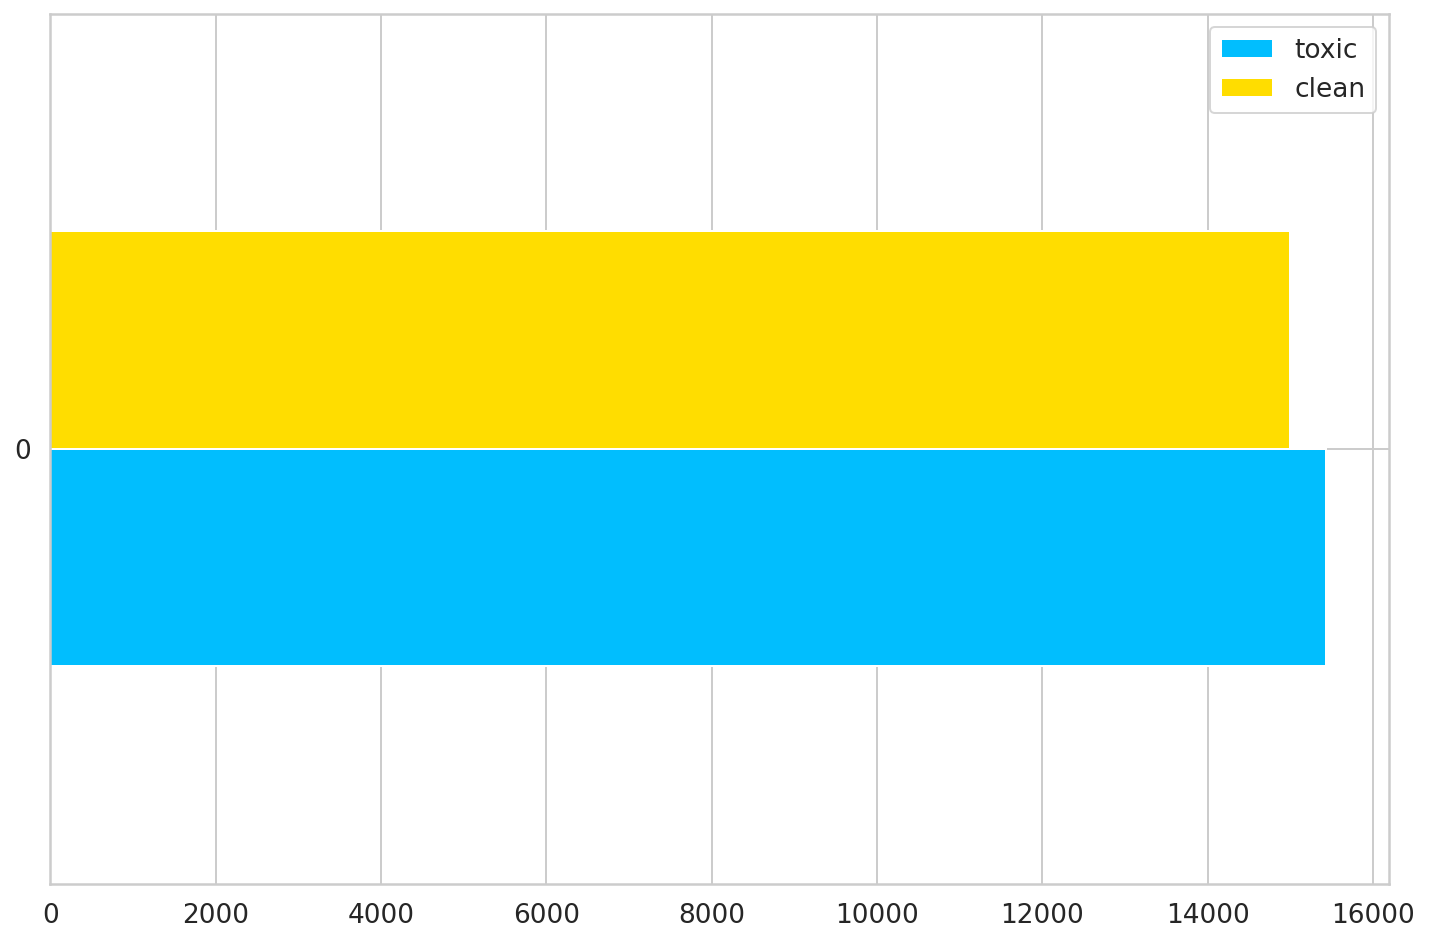

In [ ]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean.sample(15_000))]
)).plot(kind='barh');

#Balanced dataset of toxic and non_toxic comments
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

In [ ]:
class ToxicCommentsDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 128,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.test = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        _id = data_row['id']
        comment_text = data_row.comment_text
        
        if not self.test:
            labels = data_row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.test:
            return dict(
            _id = _id,
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )
        else:
            return dict(
                _id = _id,
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten()
            )
        

In [ ]:

BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# test=False
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)


In [ ]:
test_dataset = ToxicCommentsDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT,
  test=True
)


In [ ]:
sample_item = train_dataset[0]
print(sample_item.keys())
print(sample_item["_id"])
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
print(sample_item["labels"])

dict_keys(['_id', 'comment_text', 'input_ids', 'attention_mask', 'labels'])
1761d05a15926605
Hi, ya fucking idiot. ^_^
tensor([  101,  8790,   117, 11078,  8750, 10696,   119,   167,   168,   167,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

In [ ]:
sample_item = val_dataset[0]
print(sample_item.keys())
print(sample_item["_id"])
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
print(sample_item["labels"])

dict_keys(['_id', 'comment_text', 'input_ids', 'attention_mask', 'labels'])
7ca72b5b9c688e9e
Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
tensor([  101, 23880,  1584,   117,  1132,  1128,  5042,  2365,   106,  1284,
          112,  1396,  1640,  6352,  1725, 13860,  1108,  1136,  1126, 23301,
          117,   178,   119,   174,   119,  1119,  1458,  1106,  1329,   170,
         1426,  1106, 21532,  1117,   112, 11181,  1299,   119,   112,   142,
        17161,   117,  1119,  1110,   170,   188, 19756,  1776,   118,  1103,
         3714,  1104,  1126, 23301,   119,   146,  1221,   170,  2564,  1150,
         1867,  1115,   117,  1165,  1119,  3370,  1385,  1105,  1117,  3307,
         2303,  1149,   117,  1119,

In [ ]:
sample_item = test_dataset[0]
print(sample_item.keys())
print(sample_item["_id"])
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
# print(sample_item["labels"])

dict_keys(['_id', 'comment_text', 'input_ids', 'attention_mask'])
00001cee341fdb12
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
tensor([  101, 14941,  7979,   147,  1161, 11575,  1110,  1167, 28117, 19515,
         1279,  2365,  1173,  1128,   112,  1325,  1518,  1129,  1184,  1116,
         1146,  1114,  1128,  1105, 26766,  1128,  6782,   182, 10008,  8474,
         2225,   119,   119,   119,   178,  1431,  7979, 15933,   190,  1197,
        11109,  8961,  1596,  1653,  4876,  1105,  1243,  1128,  1106,  3041,
         1139,  3919,  1128,  3713,  4809,  1424,  1143,   119,   147,  1161,
         3013,  1110,  1164,  8188,  1107,  5358,  1390,  1299,   119,  1274,
   

In [ ]:
# import numpy as np
# from torch.utils.data import Subset

# num_train_examples = 100
# sample_train_ds = Subset(train_dataset, np.arange(num_train_examples))
# assert len(sample_train_ds) == num_train_examples

# num_val_examples = 100
# sample_val_ds = Subset(val_dataset, np.arange(num_val_examples))
# assert len(sample_val_ds) == num_val_examples

# num_test_examples = 100
# sample_test_ds = Subset(test_dataset, np.arange(num_test_examples))
# assert len(sample_test_ds) == num_test_examples

# train_dataloader = DataLoader(sample_train_ds, batch_size=8, shuffle=True)
# val_dataloader = DataLoader(sample_val_ds, batch_size=8, shuffle=False)
# test_dataloader = DataLoader(sample_test_ds, batch_size=8, shuffle=False)

In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
len(train_dataloader)

951

In [ ]:
import gc
gc.collect()

0

In [ ]:
# next(iter(train_dataloader))

In [ ]:
class ToxicCommentTagger(nn.Module):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) #load the pretrained bert model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # add a linear layer to the bert
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output) 
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = ToxicCommentTagger(len(LABEL_COLUMNS)).to(device)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(bert_model)

ToxicCommentTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model = bert_model

In [ ]:
# def training_step():
#     model.train()
#     input_ids = batch["input_ids"]
#     attention_mask = batch["attention_mask"]
#     labels = batch["labels"]
#     loss, outputs = model(input_ids, attention_mask, labels)
#     return {"loss": loss, "predictions": outputs, "labels": labels}

# def validation_step():
#     model.eval()
#     input_ids = batch["input_ids"]
#     attention_mask = batch["attention_mask"]
#     labels = batch["labels"]
#     with torch.no_grad():
#         loss, outputs = model(input_ids, attention_mask, labels)
#     return loss

# def test_step():
#     model.eval()
#     input_ids = batch["input_ids"]
#     attention_mask = batch["attention_mask"]
#     labels = batch["labels"]
#     with torch.no_grad():
#         loss, outputs = model(input_ids, attention_mask, labels)
#     return loss

In [ ]:
N_EPOCHS = EPOCHS


steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(380, 1900)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  avg_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
#     batch = [r.to(device) for r in batch]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)     

    # clear previously calculated gradients 
    model.zero_grad()        
    loss, outputs = model(input_ids, attention_mask, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()
    scheduler.step()

    # model predictions are stored on GPU. So, push it to CPU
    outputs=outputs.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(outputs)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  print(f"{step}: {avg_loss}")
  

    
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# import time
# from datetime import date, datetime
# from babel.dates import format_date, format_datetime, format_time

In [ ]:
from sklearn.metrics import roc_auc_score
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  #t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu

#     batch = [r.to(device) for r in batch]
    
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)   
    # deactivate autograd
    with torch.no_grad():
      
      loss, outputs = model(input_ids, attention_mask, labels)

      total_loss = total_loss + loss.item()

      outputs = outputs.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()
      total_preds.append(outputs)
      total_labels.append(labels)


  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  print(f"{step}: {avg_loss}")



  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels = np.concatenate(total_labels, axis=0)
  true = np.array(total_labels)
  pred = np.array(total_preds>0.5)
  #print(true)
  #print(pred)
  print(f"Evaluate loss {total_loss / len(val_dataloader)}")
  return avg_loss, total_preds, total_labels

In [ ]:
%%time
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
EPOCHS = 2
#for each epoch
for epoch in range(EPOCHS):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2


KeyboardInterrupt: ignored

In [ ]:
# function for evaluating the model
def test():
  
  print("\nTesting...")
  #t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  _ids = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu

#     batch = [r.to(device) for r in batch]
    _id = batch["_id"]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    #labels = batch["labels"].to(device)   
    # deactivate autograd
    with torch.no_grad():
      
      loss, outputs = model(input_ids, attention_mask)

      total_loss = total_loss + loss

      outputs = outputs#.detach().cpu().numpy()
      _ids.append(_id)
      total_preds.append(outputs)
    
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
#   _ids  = torch.cat(_ids, axis=0)
  _ids = np.concatenate(_ids, axis=0)
  total_preds  = torch.cat(total_preds, axis=0)
  results = dict(id=_ids,
      predictions = total_preds
      )
    

  return avg_loss, total_preds, results

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs#[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
avg_loss, total_preds, total_labels = evaluate()


Evaluating...
  Batch    50  of    250.
step: 50 -  avg.loss: 0
  Batch   100  of    250.
step: 100 -  avg.loss: 0
  Batch   150  of    250.
step: 150 -  avg.loss: 0
  Batch   200  of    250.
step: 200 -  avg.loss: 0
249: 0.05489310972392559
toxic roc_auc 0.9373748795478765
severe_toxic roc_auc 0.7230377262944676
obscene roc_auc 0.9324206343469568
threat roc_auc 0.6148824813148187
insult roc_auc 0.89761156707881
identity_hate roc_auc 0.7594885193813361
Evaluate loss 0.05489310972392559


label: toxic
AUC: 0.9374
Accuracy: 92.99%


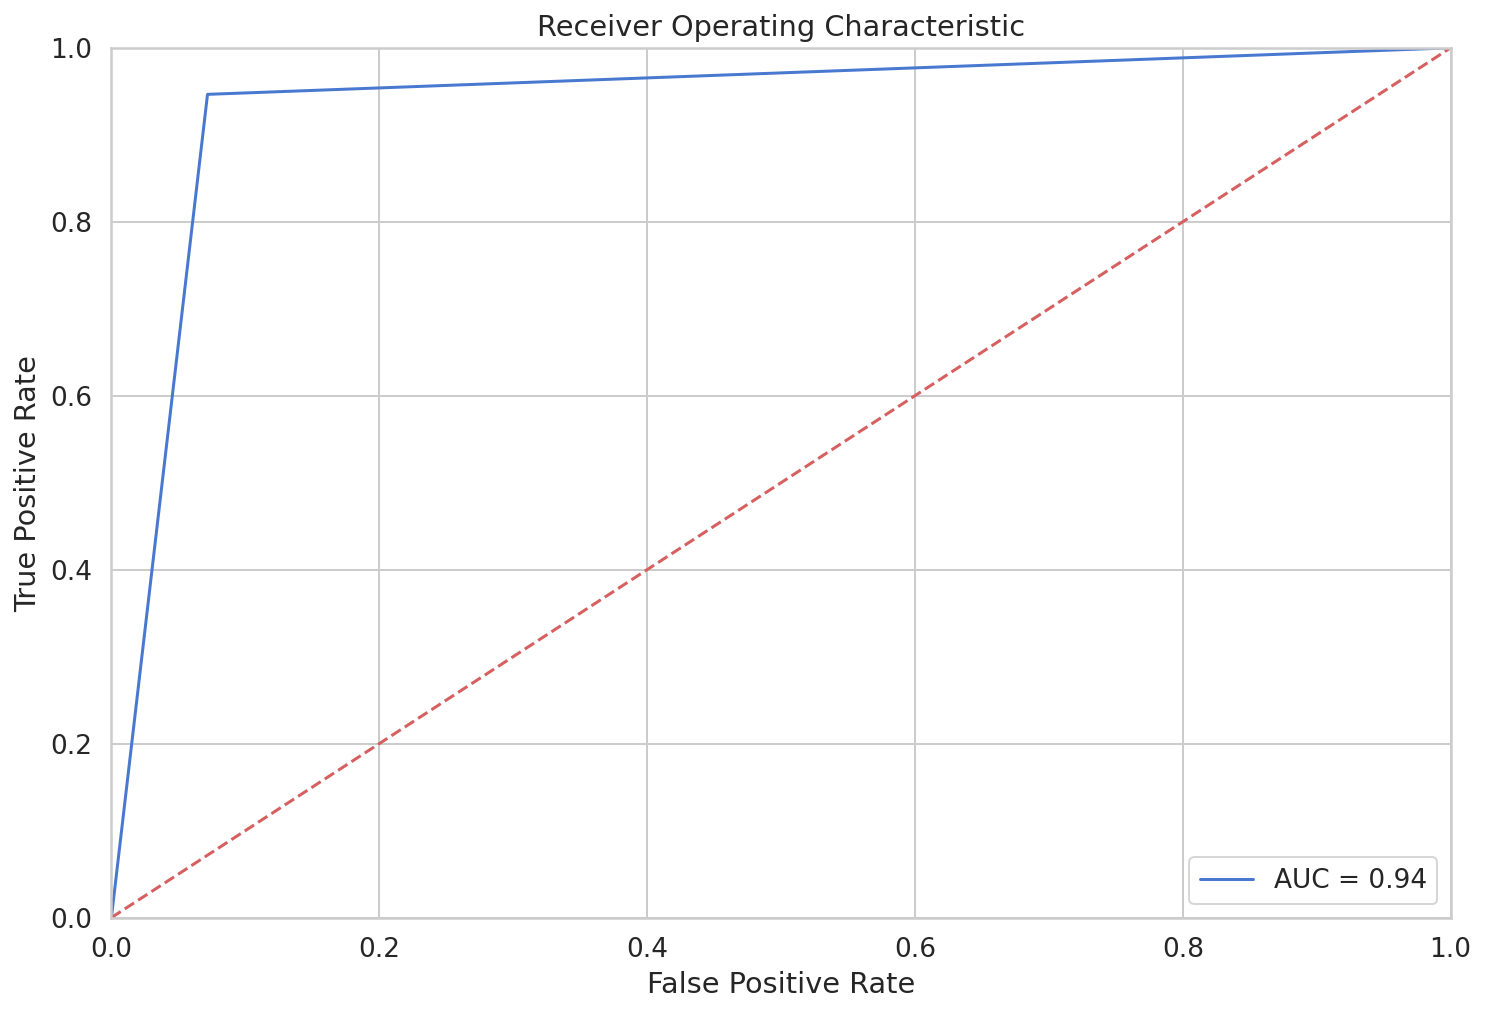

label: severe_toxic
AUC: 0.7230
Accuracy: 99.06%


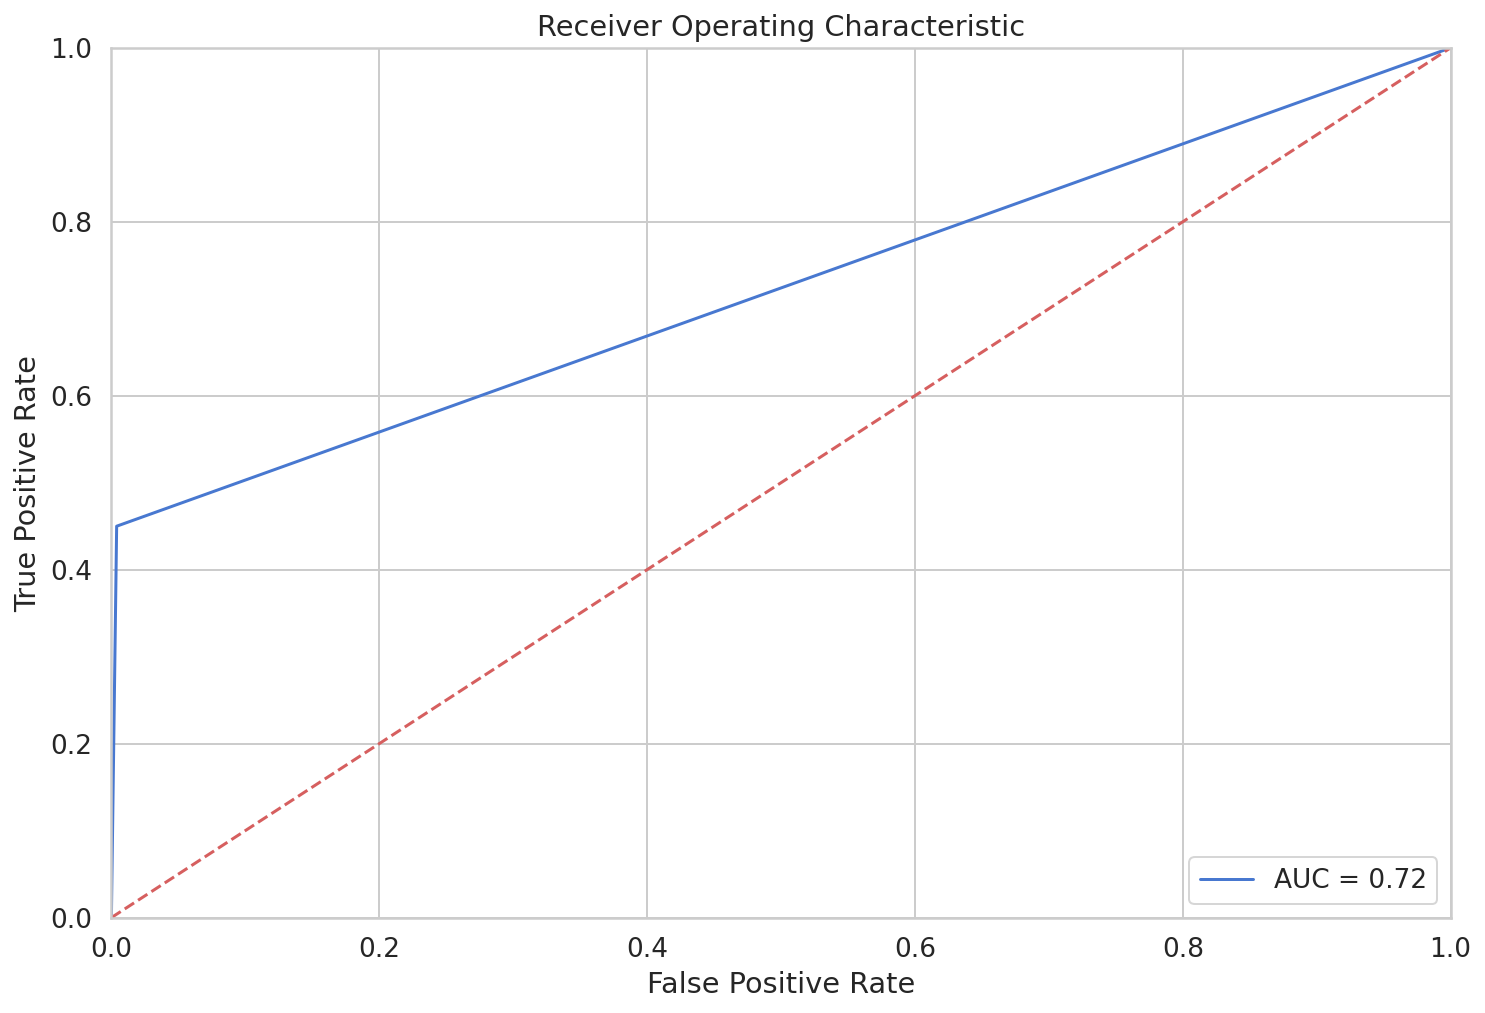

label: obscene
AUC: 0.9324
Accuracy: 98.25%


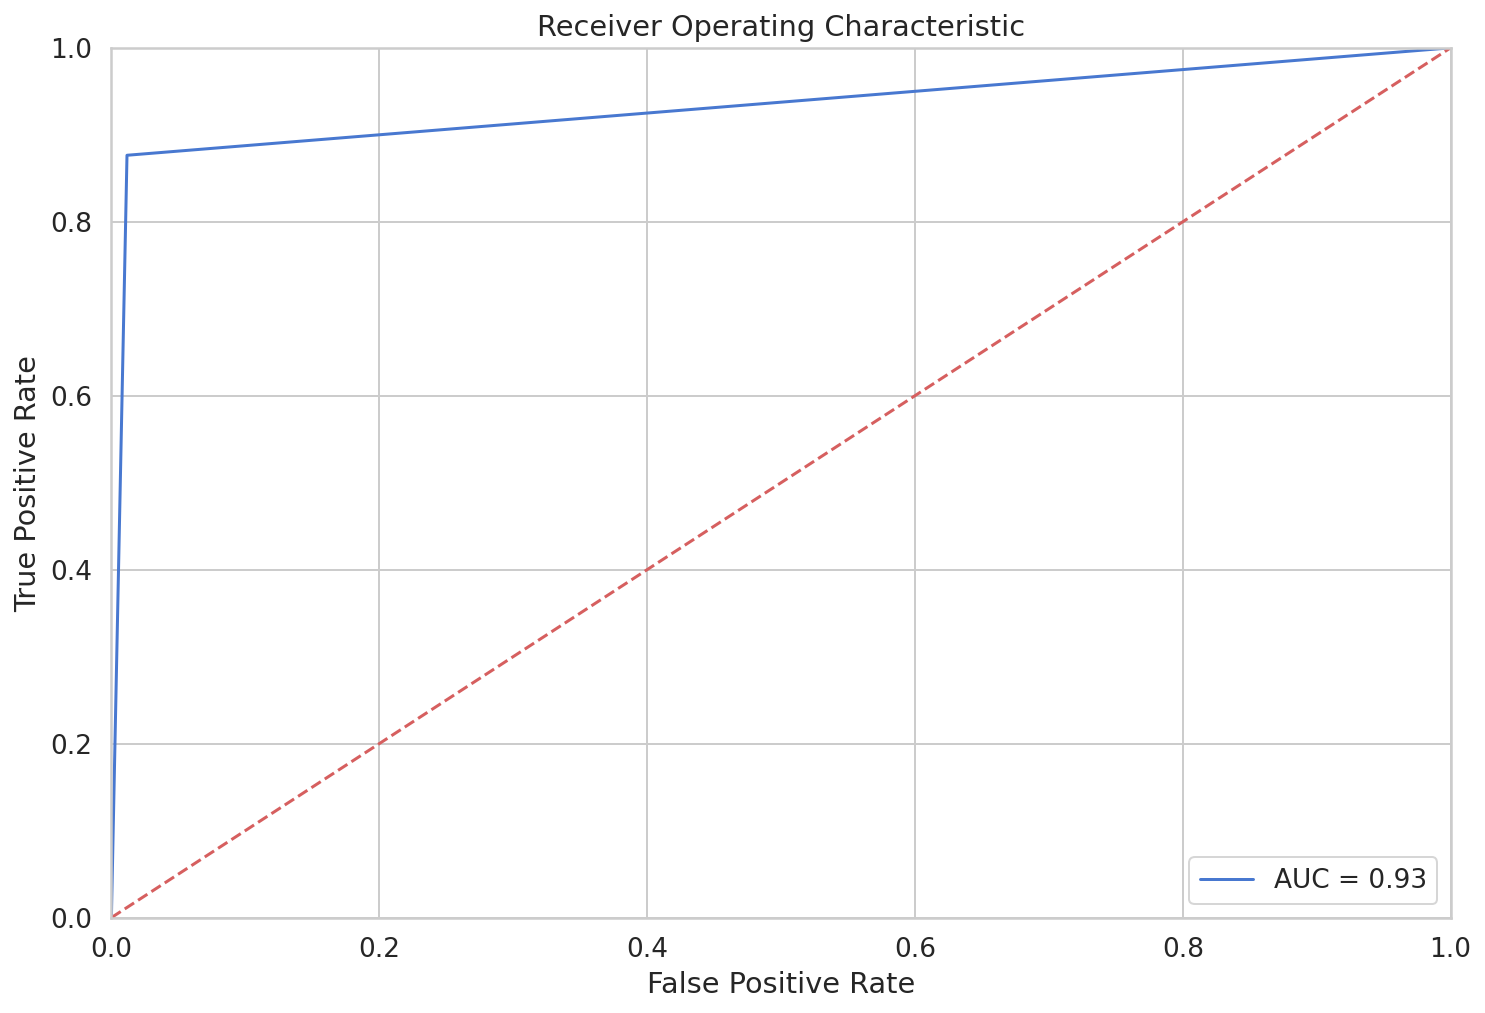

label: threat
AUC: 0.6149
Accuracy: 99.77%


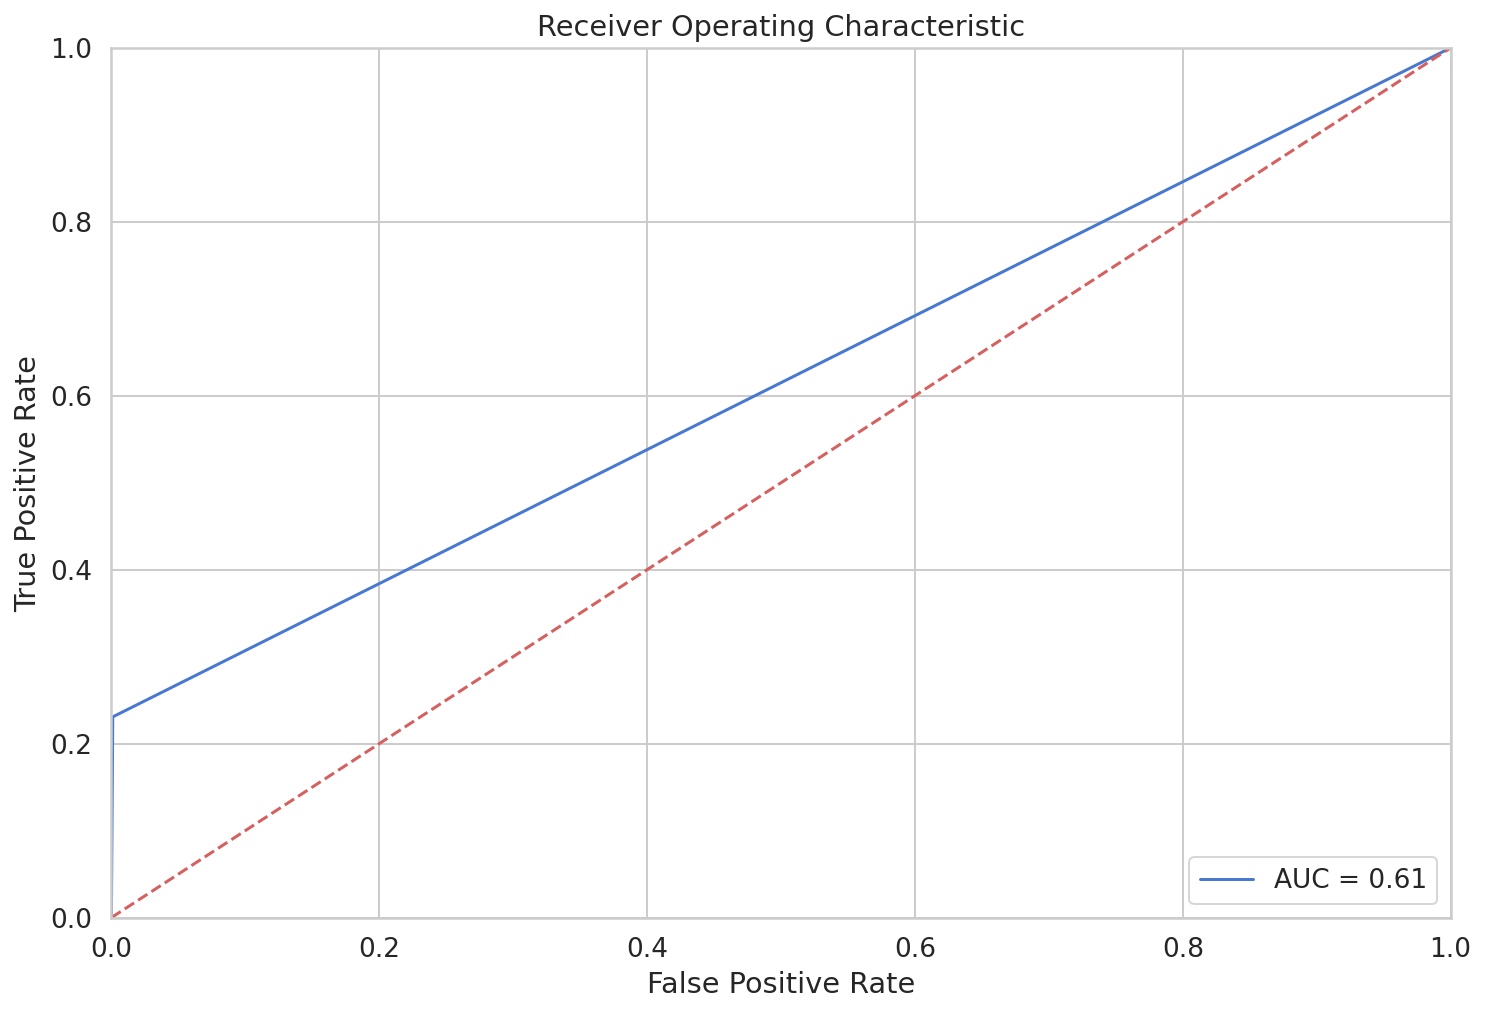

label: insult
AUC: 0.8976
Accuracy: 97.64%


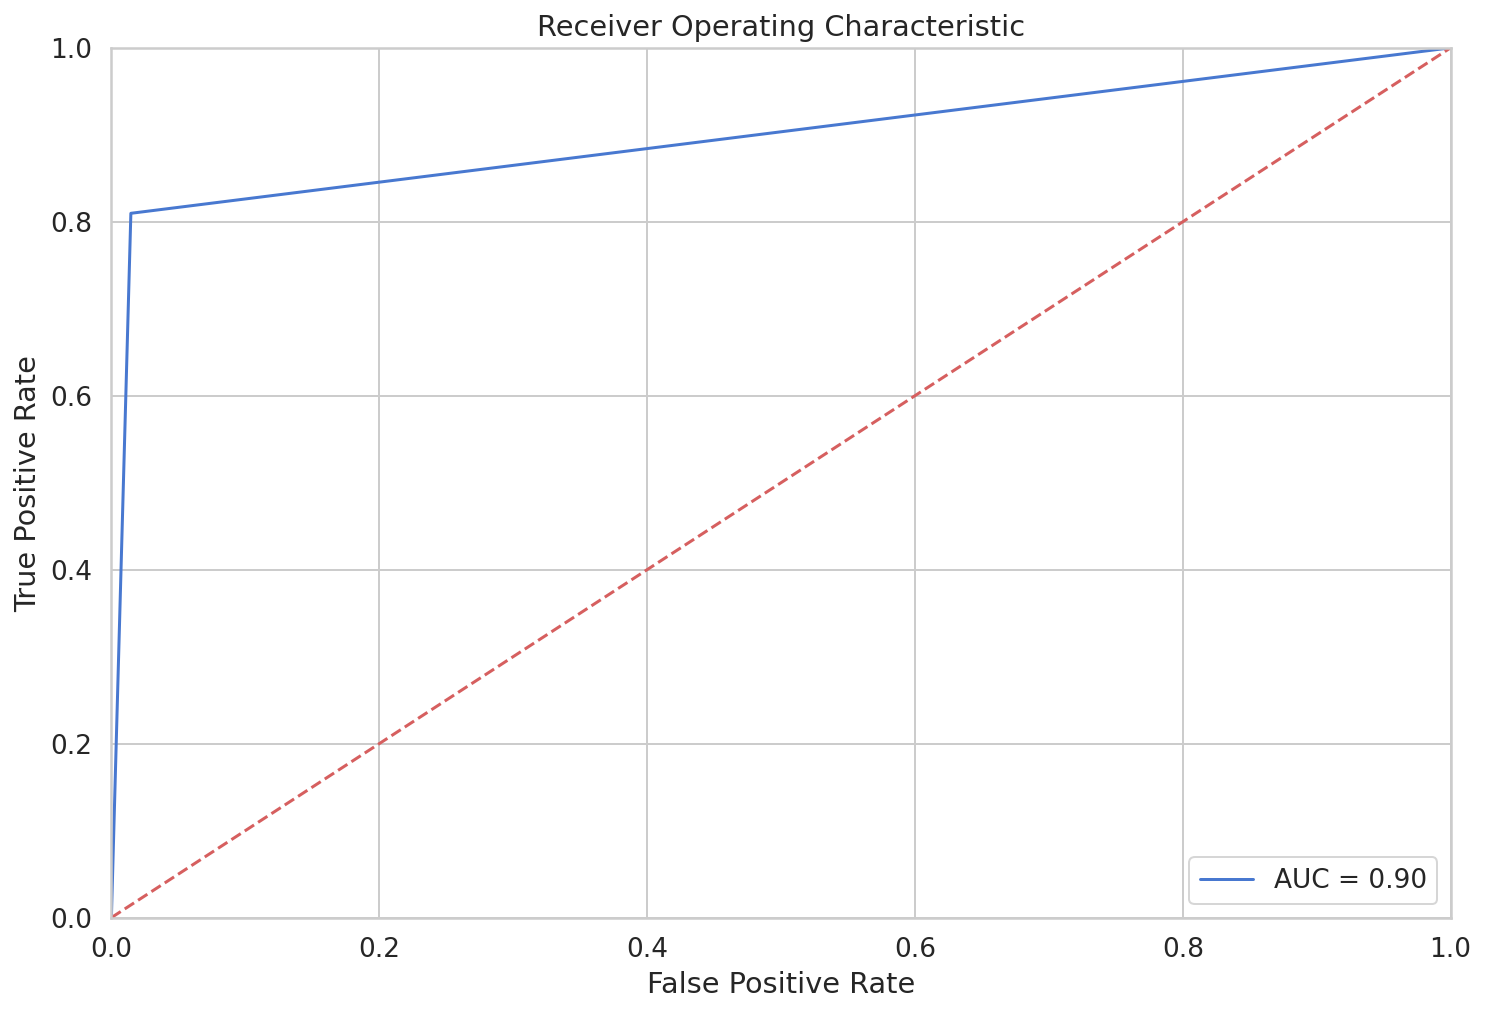

label: identity_hate
AUC: 0.7595
Accuracy: 99.36%


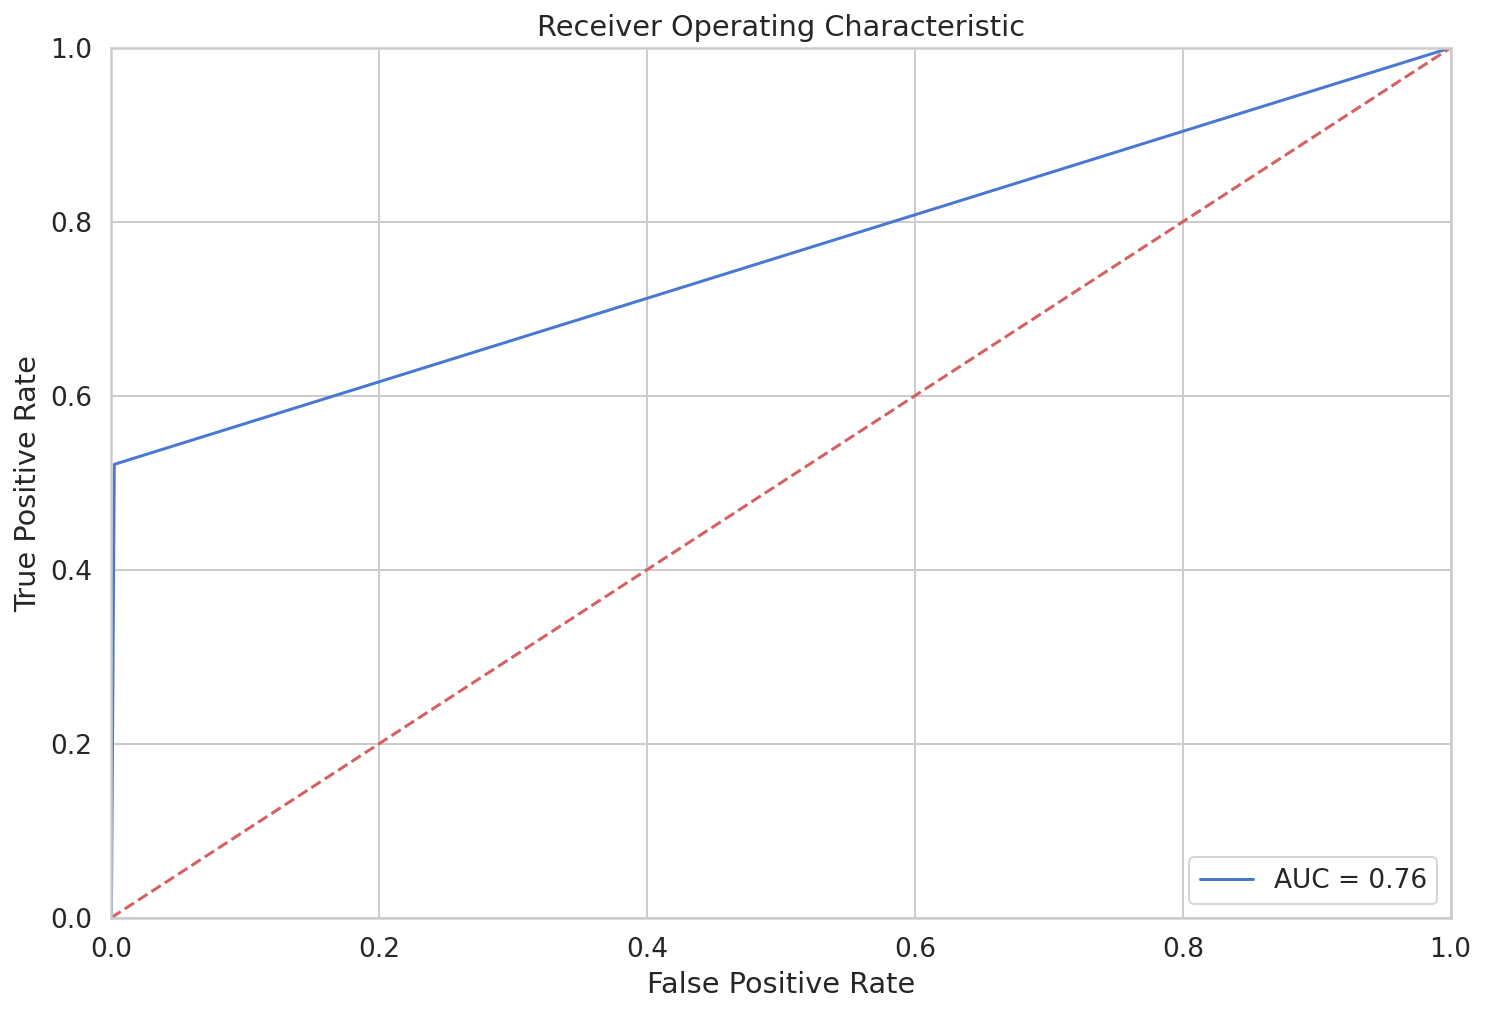

In [ ]:
for i, name in enumerate(LABEL_COLUMNS):
    print(f"label: {name}")
    evaluate_roc(total_preds[:,i]>0.5, total_labels[:,i])

In [ ]:
avg_test_loss, total_test_preds, sub = test()


Testing...
  Batch    50  of  4,787.
  Batch   100  of  4,787.
  Batch   150  of  4,787.
  Batch   200  of  4,787.
  Batch   250  of  4,787.
  Batch   300  of  4,787.
  Batch   350  of  4,787.
  Batch   400  of  4,787.
  Batch   450  of  4,787.
  Batch   500  of  4,787.
  Batch   550  of  4,787.
  Batch   600  of  4,787.
  Batch   650  of  4,787.
  Batch   700  of  4,787.
  Batch   750  of  4,787.
  Batch   800  of  4,787.
  Batch   850  of  4,787.
  Batch   900  of  4,787.
  Batch   950  of  4,787.
  Batch 1,000  of  4,787.
  Batch 1,050  of  4,787.
  Batch 1,100  of  4,787.
  Batch 1,150  of  4,787.
  Batch 1,200  of  4,787.
  Batch 1,250  of  4,787.
  Batch 1,300  of  4,787.
  Batch 1,350  of  4,787.
  Batch 1,400  of  4,787.
  Batch 1,450  of  4,787.
  Batch 1,500  of  4,787.
  Batch 1,550  of  4,787.
  Batch 1,600  of  4,787.
  Batch 1,650  of  4,787.
  Batch 1,700  of  4,787.
  Batch 1,750  of  4,787.
  Batch 1,800  of  4,787.
  Batch 1,850  of  4,787.
  Batch 1,900  of  4,787.


In [ ]:
D = pd.DataFrame()
D['id'] = sub['id']
D

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb
...,...
153159,fffcd0960ee309b5
153160,fffd7a9a6eb32c16
153161,fffda9e8d6fafa9e
153162,fffe8f1340a79fc2


In [ ]:
D[LABEL_COLUMNS] = (sub['predictions'].cpu().numpy())
D

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.986540,0.434799,0.967243,0.130517,0.950799,0.688200
1,0000247867823ef7,0.005331,0.004695,0.006866,0.005086,0.005364,0.004337
2,00013b17ad220c46,0.007648,0.003909,0.006691,0.004546,0.004666,0.004366
3,00017563c3f7919a,0.004259,0.005359,0.005865,0.006806,0.005096,0.005096
4,00017695ad8997eb,0.008092,0.003817,0.005989,0.004750,0.005252,0.003937
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.867226,0.005281,0.478026,0.002010,0.086353,0.004920
153160,fffd7a9a6eb32c16,0.021681,0.002440,0.007316,0.003922,0.006635,0.003654
153161,fffda9e8d6fafa9e,0.006966,0.003731,0.007416,0.004339,0.005165,0.004004
153162,fffe8f1340a79fc2,0.018777,0.002714,0.006707,0.003892,0.007516,0.009365


In [ ]:
D.to_csv("submission.csv", index=False)

In [ ]:
def test(model, test_dataloader):
  
  print("\nTesting...")
  #t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  _ids = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu

#     batch = [r.to(device) for r in batch]
    _id = batch["_id"]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    #labels = batch["labels"].to(device)   
    # deactivate autograd
    with torch.no_grad():
      
      loss, outputs = model(input_ids, attention_mask)

      total_loss = total_loss + loss

      outputs = outputs#.detach().cpu().numpy()
      _ids.append(_id)
      total_preds.append(outputs)
    
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
#   _ids  = torch.cat(_ids, axis=0)
  _ids = np.concatenate(_ids, axis=0)
  total_preds  = torch.cat(total_preds, axis=0)
  results = dict(id=_ids,
      predictions = total_preds
      )
    

  return avg_loss, total_preds, results

In [ ]:
model = ToxicCommentTagger(6)
model.load_state_dict(torch.load('saved_weights.pt', map_location='cpu'))
probs = test(model, test_dataloader)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Testing...
  Batch    50  of  4,787.
  Batch   100  of  4,787.
  Batch   150  of  4,787.
  Batch   200  of  4,787.
  Batch   250  of  4,787.
  Batch   300  of  4,787.
  Batch   350  of  4,787.
  Batch   400  of  4,787.
  Batch   450  of  4,787.
  Batch   500  of  4,787.
  Batch   550  of  4,787.
  Batch   600  of  4,787.
  Batch   650  of  4,787.
  Batch   700  of  4,787.
  Batch   750  of  4,787.
  Batch   800  of  4,787.
  Batch   850  of  4,787.
  Batch   900  of  4,787.
  Batch   950  of  4,787.
  Batch 1,000  of  4,787.
  Batch 1,050  of  4,787.
